# Enumerating Closed Sets of Binary Data

This notebook investigates different implementation techniques for close-by-one-style algorithms for the non-redundant enumeration of closed sets of binary datasets ('concepts' in the nomenclature of formal concept analysis). Importantly, we explore implementations that allow just-in-time compilation with numba.

## Test data

As test data we generate simple binary random matrices $R \in \{0, 1\}^{m \times n}$ with a fixed proportion of 1-entries ($\alpha=0.5$) for a range of $n$ and $m$ values.

In [1]:
import numpy as np

RNG = np.random.default_rng(seed=0)

In [2]:
def rand_array(size, alpha=0.2):
    n, k = size
    d = np.arange(n*k)
    RNG.shuffle(d)
    d = (d < alpha*len(d)).astype(np.int)
    return d.reshape(n, k)

In [3]:
d_tiny = rand_array((10, 5), alpha=0.5)
d_tiny

array([[1, 1, 0, 1, 1],
       [1, 0, 1, 1, 0],
       [1, 1, 0, 1, 1],
       [0, 0, 0, 1, 1],
       [0, 1, 0, 1, 0],
       [0, 0, 1, 1, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 1, 1],
       [1, 0, 0, 1, 1],
       [0, 0, 0, 1, 0]])

In [4]:
n = np.arange(10, 51, 5)
m = np.arange(100, 2001, 200)

alpha = 0.5

d = {}
for i in m:
    for j in n:
        d[(i, j)] = rand_array((i, j), alpha=alpha)

## Direct numpy implementation based on binary matrices

Representing data as binary matrices $R \in \{0, 1\}^{m \times n}$ and intents $c \in \{0, 1\}^n$ and extents $e \in \{0, 1\}^m$ as binary indicator vectors, allows for straightforward numpy implementations of the the intent, extent, and closure operations.

In [5]:
def intent_bm(e, d):
    return (d.T.dot(e) == e.sum()).astype(np.int)

def extent_bm(q, d):
    return (d.dot(q) == q.sum()).astype(np.int)

def closure_bm(q, d):
    return intent_bm(extent_bm(q, d), d)

def count_concepts_bm(d, r=None, i=0, print_sets=False):
    m, n  = d.shape
    r = np.zeros(n, dtype=np.int64) if r is None else r
    if print_sets: print(np.nonzero(r)[0])
    res = 1
    if i == n: return res

    for j in range(i, n):
        if r[j]: continue
        c = r.copy()
        c[j] = 1
        c = closure_bm(c, d)
        if np.array_equal(c[:j], r[:j]):
            res += count_concepts_bm(d, c, j+1, print_sets=print_sets)
    
    return res

In [6]:
count_concepts_bm(d_tiny, print_sets=True)

[]
[0 3]
[0 1 3 4]
[0 1 2 3 4]
[0 2 3]
[0 3 4]
[1]
[1 3]
[2 3]
[3]
[3 4]


11

In [7]:
t_bm = {}

for i in m:
    t_bm[(i, n[0])] = %timeit -o count_concepts_bm(d[(i, n[0])])

16 ms ± 234 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
23.8 ms ± 66.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
30.1 ms ± 135 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
35.9 ms ± 118 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
41.5 ms ± 1.98 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
45.4 ms ± 344 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
50.2 ms ± 609 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
55.5 ms ± 1.87 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
59.2 ms ± 913 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
65.3 ms ± 1.87 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
for j in n[:5]:
    t_bm[(m[0], j)] = %timeit -o count_concepts_bm(d[(m[0], j)])

16.2 ms ± 348 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
165 ms ± 16.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
758 ms ± 1.43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.9 s ± 177 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
8.84 s ± 160 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


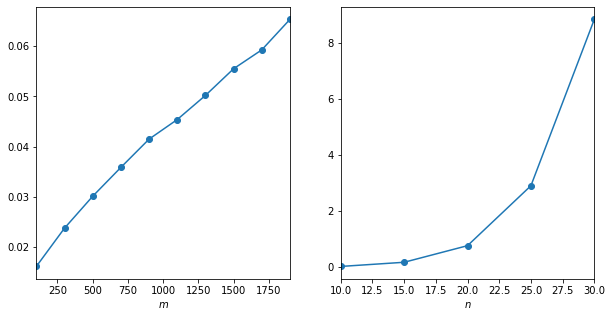

In [9]:
import matplotlib.pyplot as plt

t_bm_mean = [t_bm[(i, 10)].average for i in m]
t_bm_std = [t_bm[(i, 10)].stdev for i in m]
plt.subplots(1, 2, figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(m, t_bm_mean, marker='o')
plt.xlim(m[0], m[-1])
plt.xlabel('$m$')

plt.subplot(1, 2, 2)
t_bm_mean = [t_bm[(m[0], j)].average for j in n[:5]]
t_bm_std = [t_bm[(m[0], j)].stdev for j in n[:5]]
plt.plot(n[:5], t_bm_mean, marker='o')
plt.xlim(n[0], n[4])
plt.xlabel('$n$')

plt.show()

## Implementation based on sorted index arrays

To exploit that extents are typically relatively small for most closed sets we switch to a sparse data representation of incidence lists where the extent of attribute $i$ is represented by $e_i = [j: R_{ij}=1]$ sorted in ascending order. For convenience, we keep a similar representation of the individual object intents, which is not really needed for the close-by-one closure enumeration.

With this representation, computing the extent of a single attribute augmentation $c \cup \{j\}$ of a closed set $c$ with extent $e$ is achieved by computing the intersection $e \cap e_j$. Since the incidence lists are sorted, this intersection can be computed by a $O(\min(|e|, |e_j|))$ merge intersection. To avoid an explicit Python loop to compute the merge intersection, we use the implementation from the package sortednp (the standard numpy setops intersect1d method is much slower, because it does not rely on the array being sorted).

In [10]:
def extents(d):
    res = []
    _, k = d.shape
    for i in range(k):
        res.append(np.nonzero(d[:, i])[0])
    return res

def intents(d):
    res = []
    n, _ = d.shape
    for i in range(n):
        res.append(np.nonzero(d[i, :])[0])
    return res

In [11]:
exts_tiny, ints_tiny = extents(d_tiny), intents(d_tiny)
exts_tiny

[array([0, 1, 2, 7, 8]),
 array([0, 2, 4, 6]),
 array([1, 5]),
 array([0, 1, 2, 3, 4, 5, 7, 8, 9]),
 array([0, 2, 3, 7, 8])]

In [12]:
exts, ints = {}, {}

for i in m:
    for j in n:
        exts[(i, j)] = extents(d[(i, j)])
        ints[(i, j)] = intents(d[(i, j)])

In [13]:
import sortednp as snp

def closure_sl(q, ints, exts):
    n = len(ints)
    k = len(exts)
    ext = np.arange(n)
    for i in q:
        ext = snp.intersect(ext, exts[i])
    
    res = np.arange(k)
    for i in ext:
        res = snp.intersect(res, ints[i])

    return res

def count_concepts_sl(ints, exts, r=None, e=None, i=0, print_sets=False):
    if r is None:
        r = np.zeros(len(exts), dtype=np.int64)
        r[closure_sl(np.empty(0, dtype=np.int64), ints, exts)] = 1
        e = np.arange(len(ints))
    n = len(r)
    if print_sets: print(r.nonzero()[0])
    res = 1

    for j in range(i, n):
        if r[j]: continue
        _r = r.copy()
        _r[j] = 1
        _e = snp.intersect(e, exts[j])
        s = len(_e)

        pp = True
        for k in range(j):
            if r[k]:
                _r[k] = 1
            elif len(snp.intersect(_e, exts[k])) == s:
                pp = False
                break
        if not pp: continue

        for k in range(j+1, n):
            if len(snp.intersect(_e, exts[k])) == s:
                _r[k]=1

        res += count_concepts_sl(ints, exts, _r, _e, j+1, print_sets=print_sets)
    
    return res

In [14]:
count_concepts_sl(ints_tiny, exts_tiny, print_sets=True)

[]
[0 3]
[0 1 3 4]
[0 1 2 3 4]
[0 2 3]
[0 3 4]
[1]
[1 3]
[2 3]
[3]
[3 4]


11

In [15]:
t_sl = {}

for i in m:
    t_sl[(i, 10)] = %timeit -o count_concepts_sl(ints[(i, 10)], exts[(i, 10)])

6.09 ms ± 96.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
11 ms ± 770 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
13.7 ms ± 327 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
17.1 ms ± 1.06 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
23.8 ms ± 1.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
23.2 ms ± 854 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
25 ms ± 563 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
29 ms ± 1.41 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
31.4 ms ± 1.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
34.2 ms ± 1.81 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
for j in n[:5]:
    t_sl[(m[0], j)] = %timeit -o count_concepts_sl(ints[(m[0], j)], exts[(m[0], j)])

6.33 ms ± 289 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
71.6 ms ± 8.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
361 ms ± 19.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.42 s ± 48.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.66 s ± 402 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


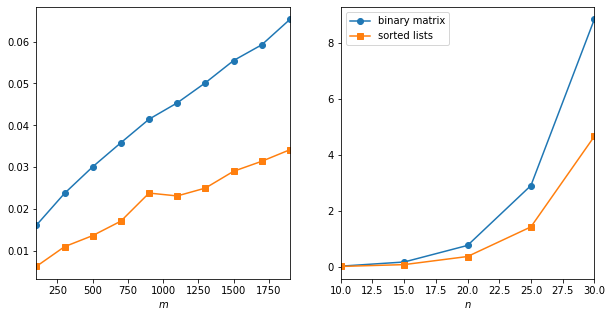

In [17]:
plt.subplots(1, 2, figsize=(10, 5))

t_bm_mean = [t_bm[(i, 10)].average for i in m]
t_bm_std = [t_bm[(i, 10)].stdev for i in m]
t_sl_mean = [t_sl[(i, 10)].average for i in m]
t_sl_std = [t_sl[(i, 10)].stdev for i in m]

plt.subplot(1, 2, 1)
plt.plot(m, t_bm_mean, marker='o')
plt.plot(m, t_sl_mean, marker='s')
plt.xlim(m[0], m[-1])
plt.xlabel('$m$')

t_bm_mean = [t_bm[(m[0], j)].average for j in n[:5]]
t_bm_std = [t_bm[(m[0], j)].stdev for j in n[:5]]
t_sl_mean = [t_sl[(m[0], j)].average for j in n[:5]]
t_sl_std = [t_sl[(m[0], j)].stdev for j in n[:5]]
plt.subplot(1, 2, 2)
plt.plot(n[:5], t_bm_mean, marker='o', label='binary matrix')
plt.plot(n[:5], t_sl_mean, marker='s', label='sorted lists')
plt.xlim(n[0], n[4])
plt.xlabel('$n$')
plt.legend()

plt.show()

## Numba just-in-time compilation

Using sortednp allows to avoid a slow Python loop for computing the merge intersections (instead using a fast C-loop). However, the close-by-one algorithm still has a nested Python for-loop over attributes. To eliminate this, we can use just-in-time compilation with the numba package. However, this requires a couple of further modifications:

1. We have to convert our Python incidence lists to numba typed lists. Otherwise numba would map our Python lists to untyped reflected lists, which would require the C-loop to inspect every list element and check for its type (removing any speed-up).

2. We have to re-implement the merge intersection, because numba does not support sortednp.

3. We have to eliminate the default arguments for the close-by-one procedure to have fixed-type compilable signatures. There are probably other solutions for this based on advanced numba features.


In [18]:
from numba.typed import List

Ints_tiny, Exts_tiny = List(ints_tiny), List(exts_tiny)

In [19]:
from numba import jit, njit, typeof, int64

@jit(nopython=True)
def intersect(s1, s2):
    res = np.zeros_like(s1)
    i, j = 0, 0
    k = 0
    m, n = len(s1), len(s2)
    while i < m and j < n:
        if s1[i] < s2[j]:
            i += 1
        elif s1[i] > s2[j]:
            j += 1
        else:
            res[k] = s1[i]
            k += 1
            i += 1
            j += 1
    return res[:k]

# @jit((int64[:], typeof(Ints1), typeof(Exts1)), nopython=True)

@njit
def closure_sl_numba(q, ints, exts):
    n = len(ints)
    k = len(exts)
    ext = np.arange(n)
    for i in q:
        ext = intersect(ext, exts[i])
    
    res = np.arange(k)
    for i in ext:
        res = intersect(res, ints[i])

    return res

@njit
def count(exts, r, e, i):
    n = len(r)
    res = 1

    for j in range(i, n):
        if r[j]: continue
        _r = r.copy()
        _r[j] = 1
        _e = intersect(e, exts[j])
        s = len(_e)

        pp = True
        for k in range(j):
            if r[k]:
                _r[k] = 1
            elif len(intersect(_e, exts[k])) == s:
                pp = False
                break
        if not pp: continue

        for k in range(j+1, n):
            if len(intersect(_e, exts[k])) == s:
                _r[k]=1

        res += count(exts, _r, _e, j+1)
    
    return res

@njit
def count_concepts_sl_numba(ints, exts):
    r = np.zeros(len(exts), dtype=int64)
    r[closure_sl_numba(np.empty(0, dtype=int64), ints, exts)] = 1
    e = np.arange(len(ints))
    return count(exts, r, e, 0)

In [20]:
count_concepts_sl_numba(Ints_tiny, Exts_tiny)

11

In [21]:
from numba.typed import List

Ints, Exts = {}, {}

for i in m:
    for j in n[: 5]:
        Ints[(i, j)] = List(ints[(i, j)])
        Exts[(i, j)] = List(exts[(i, j)])

In [22]:
t_sl_numba = {}

for i in m:
    t_sl_numba[(i, 10)] = %timeit -o count_concepts_sl_numba(Ints[(i, 10)], Exts[(i, 10)])

1.47 ms ± 30 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
3.42 ms ± 106 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.96 ms ± 10.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.81 ms ± 167 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.7 ms ± 331 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
9.98 ms ± 169 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.8 ms ± 624 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
13.4 ms ± 305 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
14.9 ms ± 173 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
16.5 ms ± 245 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
for j in n[:5]:
    t_sl_numba[(m[0], j)] = %timeit -o count_concepts_sl_numba(Ints[(m[0], j)], Exts[(m[0], j)])

1.5 ms ± 26.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
15.1 ms ± 284 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
79.9 ms ± 2.69 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
328 ms ± 23.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
962 ms ± 29.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


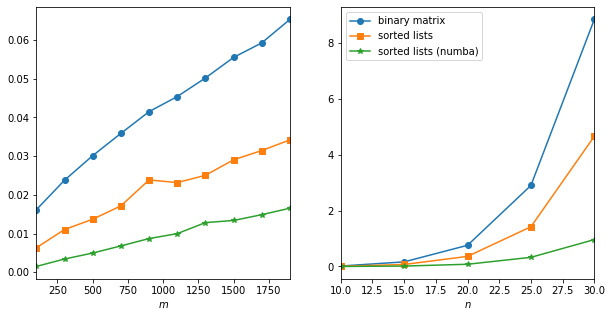

In [26]:
plt.subplots(1, 2, figsize=(10, 5))

t_bm_mean = [t_bm[(i, 10)].average for i in m]
t_bm_std = [t_bm[(i, 10)].stdev for i in m]
t_sl_mean = [t_sl[(i, 10)].average for i in m]
t_sl_std = [t_sl[(i, 10)].stdev for i in m]
t_sl_numba_mean = [t_sl_numba[(i, 10)].average for i in m]
t_sl_numba_std = [t_sl_numba[(i, 10)].stdev for i in m]

plt.subplot(1, 2, 1)
plt.plot(m, t_bm_mean, marker='o')
plt.plot(m, t_sl_mean, marker='s')
plt.plot(m, t_sl_numba_mean, marker='*')
plt.xlim(m[0], m[-1])
plt.xlabel('$m$')

t_bm_mean = [t_bm[(m[0], j)].average for j in n[:5]]
t_bm_std = [t_bm[(m[0], j)].stdev for j in n[:5]]
t_sl_mean = [t_sl[(m[0], j)].average for j in n[:5]]
t_sl_std = [t_sl[(m[0], j)].stdev for j in n[:5]]
t_sl_numba_mean = [t_sl_numba[(m[0], j)].average for j in n[:5]]
t_sl_numba_std = [t_sl_numba[(m[0], j)].stdev for j in n[:5]]

plt.subplot(1, 2, 2)
plt.plot(n[:5], t_bm_mean, marker='o', label='binary matrix')
plt.plot(n[:5], t_sl_mean, marker='s', label='sorted lists')
plt.plot(n[:5], t_sl_numba_mean, marker='*', label='sorted lists (numba)')
plt.xlim(n[0], n[4])
plt.xlabel('$n$')
plt.legend()

plt.show()